In [1]:
import torch
import non_local_boxes
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.patches as mpatches

import matplotlib.lines as mlines

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')   # in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Definitions

In [2]:
matrix_to_tensor = non_local_boxes.utils.matrix_to_tensor
tensor_to_matrix = non_local_boxes.utils.tensor_to_matrix

# Boxes as 2x2x2x2 tensors
PR = matrix_to_tensor(non_local_boxes.utils.PR)
PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
SR = matrix_to_tensor(non_local_boxes.utils.SR)
I = matrix_to_tensor(non_local_boxes.utils.I)

n = non_local_boxes.evaluate.nb_columns
W_BS09 = non_local_boxes.utils.W_BS09(n)

def WinCHSH(P): return float(non_local_boxes.evaluate.h_flat(P))                    # P is a 2x2x2x2 tensor
def WinCHSHprime(P): return float(non_local_boxes.evaluate.h_prime_flat(P))         # P is a 2x2x2x2 tensor
def BoxProduct(W,P,Q): return non_local_boxes.evaluate.R_tensor(W,P,Q)[:,:,:,:,0]   # P,Q are is a 2x2x2x2 tensor

def Catalan_number(k):
    return int(math.factorial(2*(k-1))/(math.factorial(k)*math.factorial(k-1)))

P = PR
print(WinCHSH(P), WinCHSHprime(P))
for k in range(1,11):
    print(k, Catalan_number(k))

1.0 0.5
1 1
2 1
3 2
4 5
5 14
6 42
7 132
8 429
9 1430
10 4862


In [3]:
def Compute_Coeff(P1, P2, P3, CHSHprime_value, CHSH_value):
    A = np.array([[WinCHSHprime(P1), WinCHSHprime(P2), WinCHSHprime(P3)],
                  [WinCHSH(P1), WinCHSH(P2), WinCHSH(P3)],
                  [1, 1, 1]])
    b = np.array([CHSHprime_value, CHSH_value, 1])
    return np.linalg.solve(A,b).tolist()

In [4]:
def eta(P, x, y):
    return 2*P[0, x*y, x, y] + 2*P[1, (1+x*y)%2, x, y] -1

def BBP23_value(P):
    A = (eta(P,0,0)+eta(P,0,1)+eta(P,1,0)+eta(P,1,1))**2
    B = 2*eta(P,0,0)**2+4*eta(P, 1,0)*eta(P,0,1) + 2*eta(P, 1,1)**2
    return A+B

In [5]:
def Compute_Orbits(P, W, max_depth):
    Orbits = [[P]]  # each all_orbits[k] is a list, which is the orbit of depth k+1
    for k in range(max_depth-1):
          Orbits.append([])
          for l in range(k+1):
                for Q1 in Orbits[l]:
                      for Q2 in Orbits[k-l]:
                            Orbits[k+1].append( BoxProduct(W, Q1, Q2) )
    return Orbits

In [6]:
def Compute_Orbit_BS09(P, W, max_depth):
    OrbitBS09 = [P]
    k = 1
    while 2**k<=max_depth:
        k += 1
        Q = OrbitBS09[-1]
        OrbitBS09.append( BoxProduct(W, Q, Q) )
    return OrbitBS09

In [7]:
def E(Box, x, y):
    return Box[0,0,x,y] + Box[1,1,x,y] - Box[0,1,x,y] - Box[1,0,x,y]

def is_in_Q(CHSHprime_value,CHSH_value, Box1=PR, Box2=SR, Box3=I):
    alpha, beta, gamma = Compute_Coeff(Box1, Box2, Box3, CHSHprime_value=CHSHprime_value, CHSH_value=CHSH_value)
    Box = alpha*Box1 + beta*Box2 + gamma*Box3
        # Box is a 2x2x2x2 tensor
    coeff00 = np.arcsin(E(Box,0,0))
    coeff01 = np.arcsin(E(Box,0,1))
    coeff10 = np.arcsin(E(Box,1,0))
    coeff11 = np.arcsin(E(Box,1,1))
    return coeff00 + coeff01 + coeff10 - coeff11 <= np.pi

In [8]:
def Draw_Orbit(P, P1, P1name, P2, P2name, P3, P3name, W, Wname, max_depth, details_BS09=False, precision_Q=0.0001):
    # P, P1, P2, P3 are 2x2x2x2 matrices

    # Draw the initial background triangle:
    x1, y1 = WinCHSHprime(P1), WinCHSH(P1)
    x2, y2 = WinCHSHprime(P2), WinCHSH(P2)
    x3, y3 = WinCHSHprime(P3), WinCHSH(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned:
    if (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3):
            print("\n    WARNING: Error in the coordinate system.")
            return None

    triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=hsv_to_rgb([0.475, 1, 0.9]))
    plt.gca().add_patch(triangle)

    BBLMTU_value = (3+math.sqrt(6))/6
    BBLMTU_rectangle = plt.Polygon(np.array([[0.5, 1.0], [0.5,BBLMTU_value], [1.5-BBLMTU_value, BBLMTU_value]]), color=hsv_to_rgb([0.475, 1, 0.5]))
    plt.gca().add_patch(BBLMTU_rectangle)

    # Draw the Quantum area
    CHSHprime_value=0.5
    CHSH_value=(2+np.sqrt(2))/4
    Quantum_color = 'pink'
    while CHSHprime_value<=0.75:
        if is_in_Q(CHSHprime_value, CHSH_value):
            plt.plot([CHSHprime_value, CHSHprime_value], [CHSH_value, 0.75], color=Quantum_color)
            CHSHprime_value+=precision_Q
        else:
            CHSH_value= max(CHSH_value-precision_Q, 0.75)
    plt.plot(0.75, 0.75,'o', markersize=0.7, color=Quantum_color)

    # Draw the orbit:
    Orbits = Compute_Orbits(P, W, max_depth)
    for k in range(len(Orbits)):
        color = hsv_to_rgb([k/(7*(len(Orbits)-1)), 1, 1])
        for Q in Orbits[k]:  # Q is a tensor
            # Compute the abscissa and the ordinate:
            x = WinCHSHprime(Q)
            if x>=0.5:
                y = WinCHSH(Q)
                plt.plot(x, y, 'o', markersize=4, color=color)
                if k==2-1 and details_BS09:
                     plt.text(x, y, "  ← orbit of depth $k=2$", horizontalalignment='left', verticalalignment = 'center')
                     
    
    # Draw the orbit from [BS09]:
    if details_BS09:
        OrbitBS09 = Compute_Orbit_BS09(P, W, max_depth)
        for Q in OrbitBS09:
            x = WinCHSHprime(Q)
            if x>=0.5:
                y = WinCHSH(Q)
                plt.plot(x, y, 'o', markersize=4, mfc='none', color='black')
    
    plt.text(WinCHSHprime(P), WinCHSH(P), "  ← starting box $\mathbf{P}$", horizontalalignment='left', verticalalignment = 'center')
    plt.text(x1+0.001, y1, P1name, horizontalalignment='center',weight="bold")
    plt.text(x2, y2+0.007, P2name, verticalalignment='center',weight="bold")
    plt.text(x3, y3-0.007, P3name, verticalalignment='center',weight="bold")
    plt.title("Orbit of a box $\mathbf{P}$ until depth $k=$"+str(max_depth)+" (wiring $\mathsf{W}=$"+Wname+")")
    plt.xlabel("$\mathbb{P}($win at CHSH'$)$")
    plt.ylabel("$\mathbb{P}($win at CHSH$)$")
    handles = []
    handles.append( mpatches.Patch(color=hsv_to_rgb([0.475, 1, 0.5]), label='Collapsing $\mathcal{N\!S}$-boxes from [BBLMTU06].') )
    handles.append( mpatches.Patch(color=hsv_to_rgb([0.475, 1, 0.8]), label='Other $\mathcal{N\!S}$-boxes.') )
    handles.append( mpatches.Patch(color=Quantum_color, label='Quantum boxes.') )
    handles.append( mlines.Line2D([], [],color=hsv_to_rgb([0.0, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(1)+".") )
    handles.append(  mlines.Line2D([], [],color=hsv_to_rgb([1/14, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(max_depth//2)+".") )
    handles.append( mlines.Line2D([], [],color=hsv_to_rgb([1/7, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(max_depth)+".") )
    if details_BS09:
        handles.append( mlines.Line2D([], [],color='black', mfc='none', marker='o',ls='', label='Boxes studied in [BS09].') )
    plt.legend(handles=handles, loc='upper right', fontsize = 9)
    plt.show()


# Compute the Orbit

/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_32351/2196004311.py:8: RuntimeWarning: invalid value encountered in arcsin
  coeff00 = np.arcsin(E(Box,0,0))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_32351/2196004311.py:9: RuntimeWarning: invalid value encountered in arcsin
  coeff01 = np.arcsin(E(Box,0,1))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_32351/2196004311.py:10: RuntimeWarning: invalid value encountered in arcsin
  coeff10 = np.arcsin(E(Box,1,0))


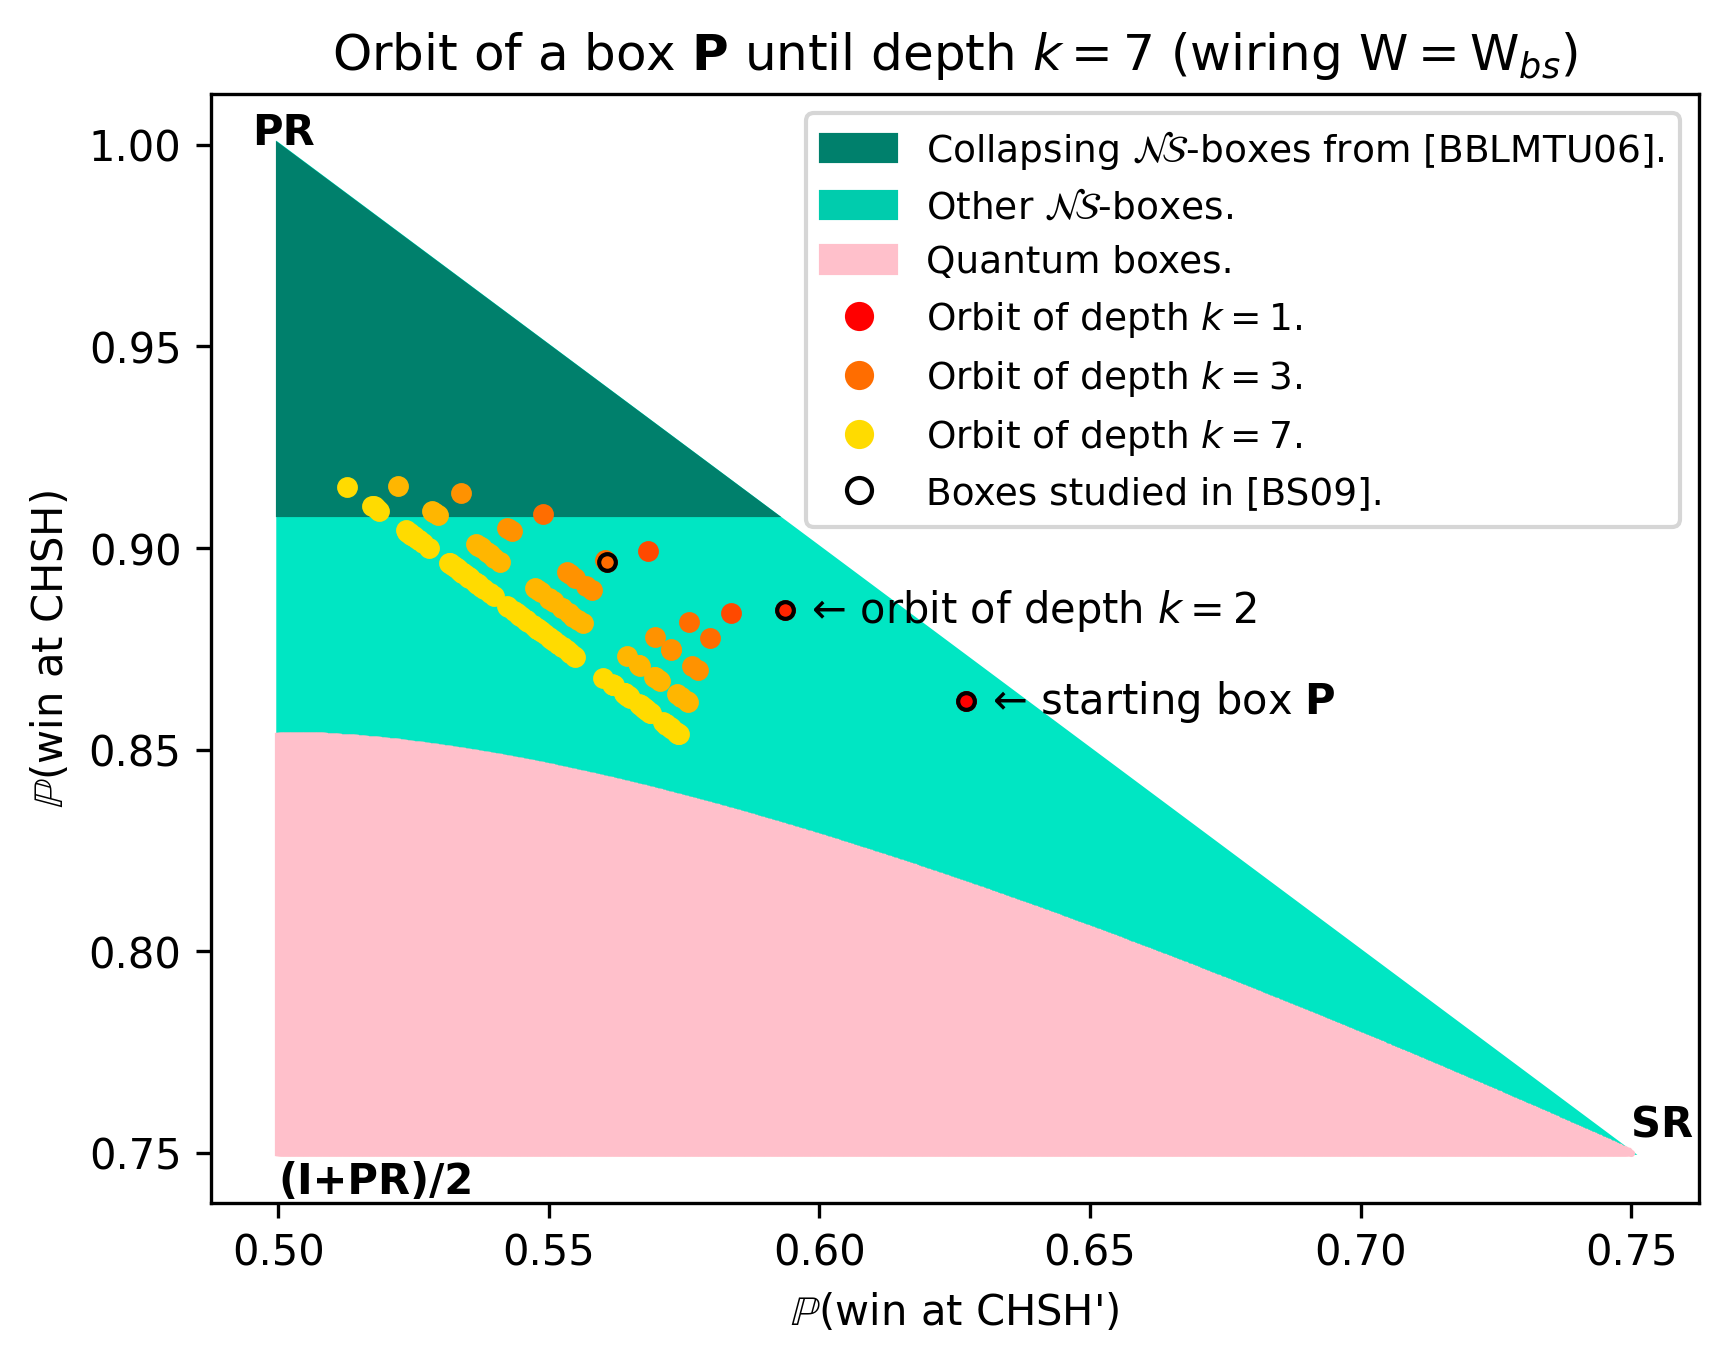

In [9]:
# alpha = 0.47
# beta = 0.51

# set nb_columns=1

alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
P = alpha*PR + beta*SR + (1-alpha-beta)*I

Draw_Orbit(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = SR,
    P2name = "SR",
    P3 = (I+PR)/2,
    P3name = "(I+PR)/2",
    W = W_BS09,
    Wname = "$\mathsf{W}_{bs}$",
    max_depth = 7, 
    details_BS09=True,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x ⊕ x·a1
g_2(y,b1) = y ⊕ y·b1
f_3(x,a1,a2) = a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/3214038476.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/2196004311.py:8: RuntimeWarning: invalid value encountered in arcsin
  coeff00 = np.arcsin(E(Box,0,0))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/2196004311.py:9: RuntimeWarning: invalid value encountered in arcsin
  coeff01 = np.arcsin(E(Box,0,1))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/2196004311.py:10: RuntimeWarning: invalid value encountered in arcsin
  coeff10 = np.arcsin(E(Box,1,0))


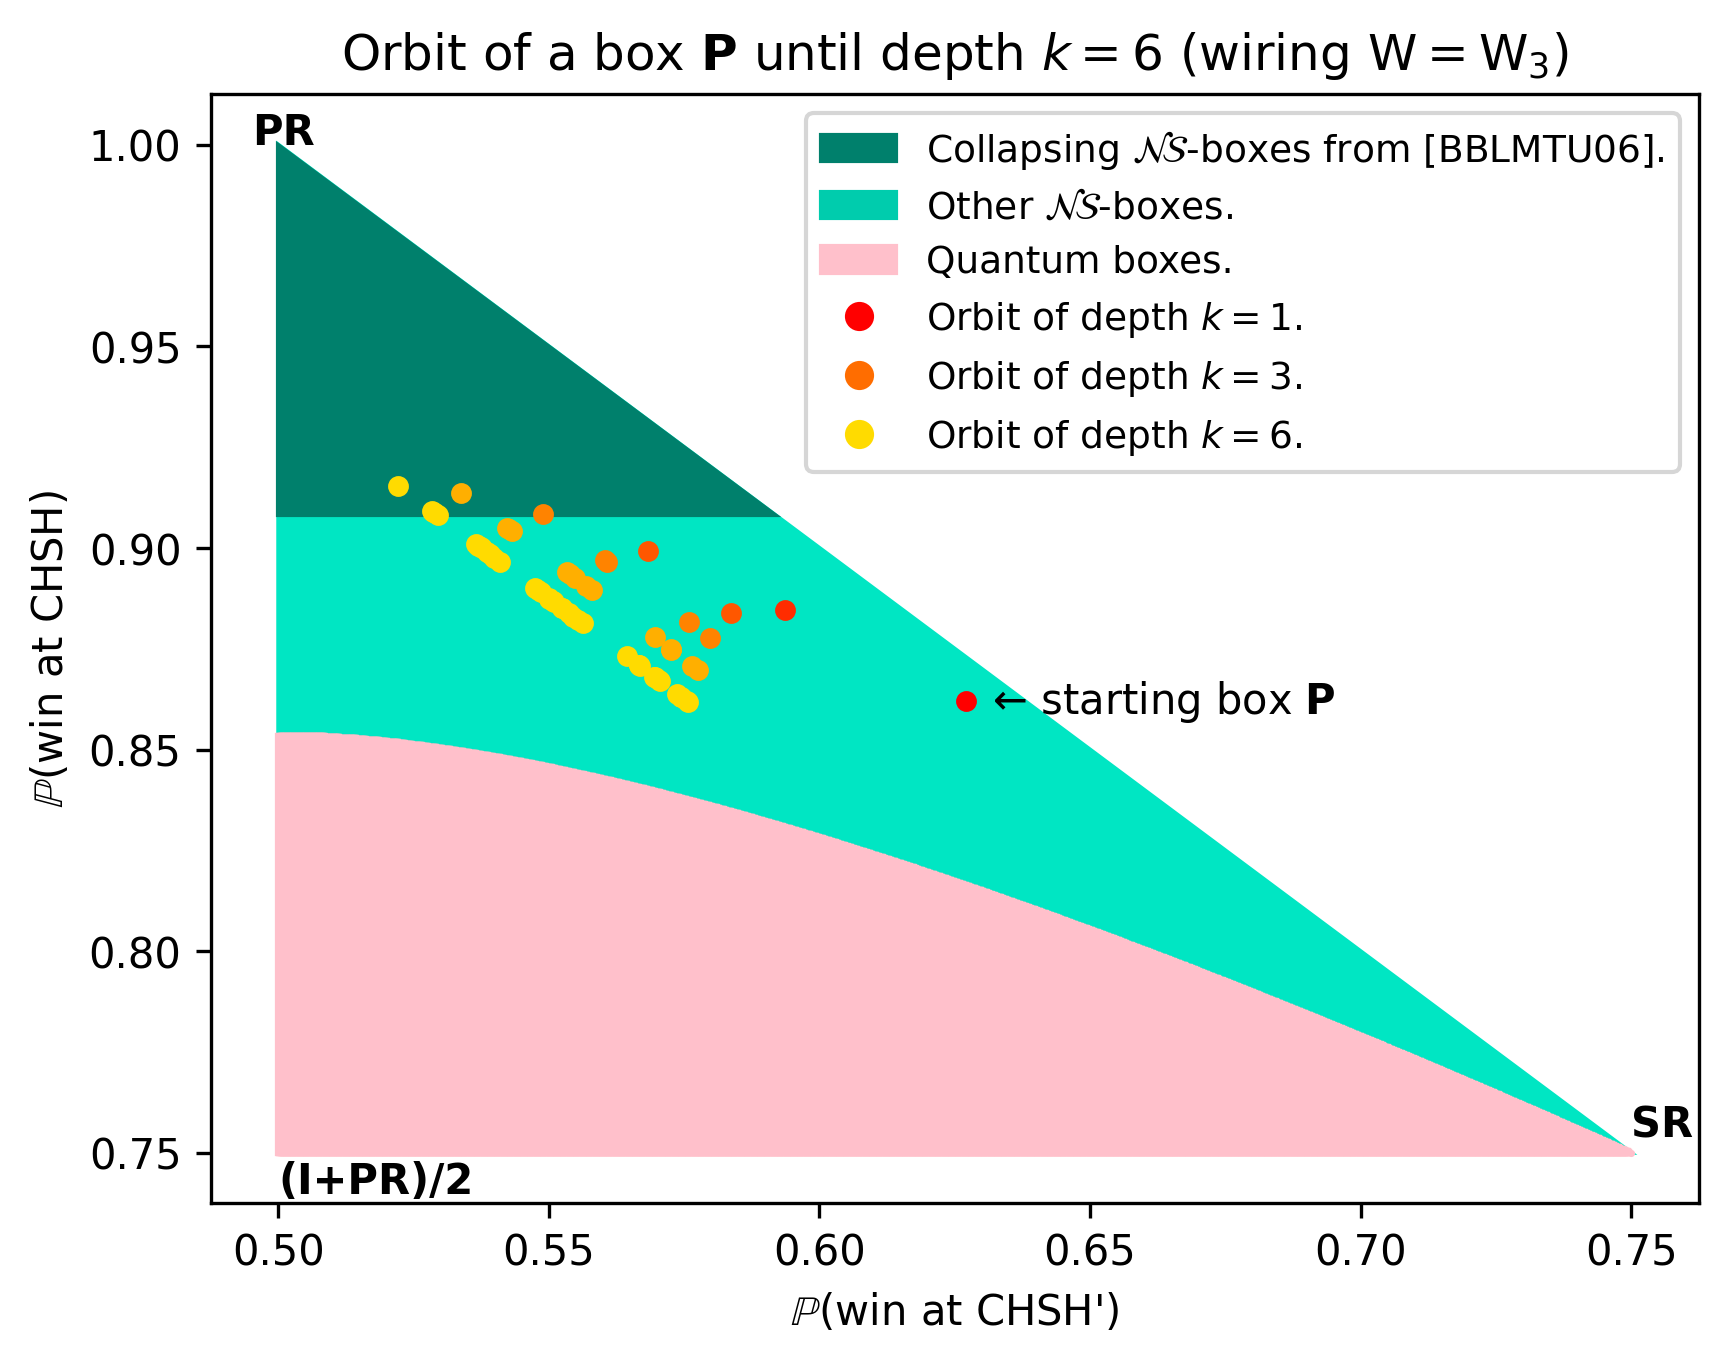

In [131]:
#alpha = 0.47
#beta = 0.51

# set nb_columns=1

alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
P = alpha*PR + beta*SR + (1-alpha-beta)*I

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[16] )*1.
#W =  [0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))



Draw_Orbit(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = SR,
    P2name = "SR",
    P3 = (I+PR)/2,
    P3name = "(I+PR)/2",
    W = W,
    Wname = "$\mathsf{W}_{3}$",
    max_depth = 6,
    precision_Q=0.0001
)

In [133]:
non_local_boxes.utils.known_collapsing_W[16]==[0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,0.,0.,0.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.]

True

------
------
------
# Other Stuff

In [12]:
W = W_BS09
max_depth = 6

print("BBLMTU value: ", (3+math.sqrt(6))/6)
print("------")

Orbits = Compute_Orbits(P, W, max_depth)
for k in range(len(Orbits)):
    y = 0
    for Q in Orbits[k]:
        y = max(WinCHSH(Q), y)
    print("For k=",k+1,", CHSH value = ",y)

print("------")
print("ORBIT BS09")
OrbitBS09 = Compute_Orbit_BS09(P, W, 2**max_depth)
for Q in OrbitBS09:
    y = WinCHSH(Q)
    print(y)

BBLMTU value:  0.908248290463863
------
For k= 1 , CHSH value =  0.8619999289512634
For k= 2 , CHSH value =  0.8845272660255432
For k= 3 , CHSH value =  0.8993690013885498
For k= 4 , CHSH value =  0.9085418581962585
For k= 5 , CHSH value =  0.9135439395904541
For k= 6 , CHSH value =  0.9154865741729736
------
ORBIT BS09
0.8619999289512634
0.8845272660255432
0.8966295123100281
0.8868539929389954
0.8422612547874451
0.7549486756324768
0.6394163370132446


In [10]:
x = WinCHSHprime(P)
y = WinCHSH(P)
print(x,y)
print(BBP23_value(P))

0.6269999742507935 0.8619999289512634
tensor(14.1286)


In [13]:
OrbitBS09 = Compute_Orbit_BS09(P, W, 2**max_depth)
for Q in OrbitBS09:
    print("---")
    OrbitBS09_Q = Compute_Orbit_BS09(Q, W, 2**max_depth)
    for R in OrbitBS09_Q:
        y = WinCHSH(R)
        print(y)

---
0.8619999289512634
0.8845272660255432
0.8966295123100281
0.8868539929389954
0.8422612547874451
0.7549486756324768
0.6394163370132446
---
0.8845272660255432
0.8966295123100281
0.8868539929389954
0.8422612547874451
0.7549486756324768
0.6394163370132446
0.5455975532531738
---
0.8966295123100281
0.8868539929389954
0.8422612547874451
0.7549486756324768
0.6394163370132446
0.5455975532531738
0.5089374780654907
---
0.8868539929389954
0.8422612547874451
0.7549486756324768
0.6394163370132446
0.5455975532531738
0.5089374780654907
0.5019333958625793
---
0.8422612547874451
0.7549486756324768
0.6394163370132446
0.5455975532531738
0.5089374780654907
0.5019333958625793
0.5004820823669434
---
0.7549486756324768
0.6394163370132446
0.5455975532531738
0.5089374780654907
0.5019333958625793
0.5004820823669434
0.5001338124275208
---
0.6394163370132446
0.5455975532531738
0.5089374780654907
0.5019333958625793
0.5004820823669434
0.5001338124275208
0.5000609159469604


-----

In [23]:
def Gvalue(P):
    # P is a 2x2x2x2 tensor
    game = torch.zeros((2,2,2,2))
    for a in range(2):
        for b in range(2):
            for x in range(2):
                for y in range(2):
                    if a == 0 and b == y:
                        game[a,b,x,y]=0.25
    return float(torch.sum(P*game))

In [140]:
def Draw_Orbit2(P, P1, P1name, P2, P2name, P3, P3name, W, Wname, max_depth, details_BS09=False, precision_Q=0.0001):
    # P, P1, P2, P3 are 2x2x2x2 matrices

    # Draw the initial background triangle:
    x1, y1 = Gvalue(P1), WinCHSH(P1)
    x2, y2 = Gvalue(P2), WinCHSH(P2)
    x3, y3 = Gvalue(P3), WinCHSH(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned:
    if (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3):
            print("\n    WARNING: Error in the coordinate system.")
            return None

    triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=hsv_to_rgb([0.475, 1, 0.9]))
    plt.gca().add_patch(triangle)

    BBLMTU_value = (3+math.sqrt(6))/6
    BBLMTU_rectangle = plt.Polygon(np.array([[x1, y1], [x1+(x2-x1)*(1-BBLMTU_value)/(1-y2),BBLMTU_value], [x1 - (x1-x3)*(1-BBLMTU_value)/(1-y3), BBLMTU_value]]), color=hsv_to_rgb([0.475, 1, 0.5])) # use Thales theorem
    plt.gca().add_patch(BBLMTU_rectangle)

    # # Draw the Quantum area
    # G_value=min(x2,x3)
    # CHSH_value=(2+np.sqrt(2))/4
    Quantum_color = 'pink'
    # while G_value<=max(x2, x3):
    #     if is_in_Q(G_value, CHSH_value, P1, P2, P3):
    #         plt.plot([G_value, G_value], [CHSH_value, y2], color=Quantum_color)
    #         G_value+=precision_Q
    #     else:
    #         CHSH_value= max(CHSH_value-precision_Q, y2)
    # #plt.plot(0.75, 0.75,'o', markersize=0.7, color=Quantum_color)
    plt.plot([min(x2,x3), max(x2, x3)], [y2,y2], markersize=0.7, color=Quantum_color)
    plt.plot([min(x2,x3), max(x2, x3)], [y2,y2], "o", markersize=3, color=Quantum_color)

    # Draw the orbit:
    Orbits = Compute_Orbits(P, W, max_depth)
    for k in range(len(Orbits)):
        color = hsv_to_rgb([k/(7*(len(Orbits)-1)), 1, 1])
        for Q in Orbits[k]:  # Q is a tensor
            # Compute the abscissa and the ordinate:
            x = Gvalue(Q)
            y = WinCHSH(Q)
            plt.plot(x, y, 'o', markersize=4, color=color)
            if k==2-1 and details_BS09:
                    plt.text(x, y, "  ← orbit of depth $k=2$", horizontalalignment='left', verticalalignment = 'center')
                     
    
    # Draw the orbit from [BS09]:
    if details_BS09:
        OrbitBS09 = Compute_Orbit_BS09(P, W, max_depth)
        for Q in OrbitBS09:
            x = Gvalue(Q)
            if x>=0.5:
                y = WinCHSH(Q)
                plt.plot(x, y, 'o', markersize=4, mfc='none', color='black')
    
    plt.text(Gvalue(P), WinCHSH(P), "  ← starting box $\mathbf{P}$", horizontalalignment='left', verticalalignment = 'center')
    plt.text(x1+0.001, y1, P1name, horizontalalignment='center',weight="bold")
    plt.text(x2, y2-0.007, P2name, verticalalignment='center',weight="bold")
    plt.text(x3, y3-0.007, P3name, verticalalignment='center',weight="bold")
    plt.title("Orbit of a box $\mathbf{P}$ until depth $k=$"+str(max_depth)+" (wiring $\mathsf{W}=$"+Wname+")")
    plt.xlabel("$\mathbb{P}($win at the game G$)$")
    plt.ylabel("$\mathbb{P}($win at CHSH$)$")
    handles = []
    handles.append( mpatches.Patch(color=hsv_to_rgb([0.475, 1, 0.5]), label='Collapsing $\mathcal{N\!S}$-boxes from [BBLMTU06].') )
    handles.append( mpatches.Patch(color=hsv_to_rgb([0.475, 1, 0.8]), label='Other $\mathcal{N\!S}$-boxes.') )
    handles.append( mpatches.Patch(color=Quantum_color, label='Quantum boxes.') )
    handles.append( mlines.Line2D([], [],color=hsv_to_rgb([0.0, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(1)+".") )
    handles.append(  mlines.Line2D([], [],color=hsv_to_rgb([1/14, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(max_depth//2)+".") )
    handles.append( mlines.Line2D([], [],color=hsv_to_rgb([1/7, 1, 1]), marker='o',ls='', label='Orbit of depth $k=$'+str(max_depth)+".") )
    if details_BS09:
        handles.append( mlines.Line2D([], [],color='black', mfc='none', marker='o',ls='', label='Boxes studied in [BS09].') )
    plt.legend(handles=handles, loc='upper left', fontsize = 9)
    plt.show()


f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x·a1
g_2(y,b1) = y·b1
f_3(x,a1,a2) = a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/1861597236.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


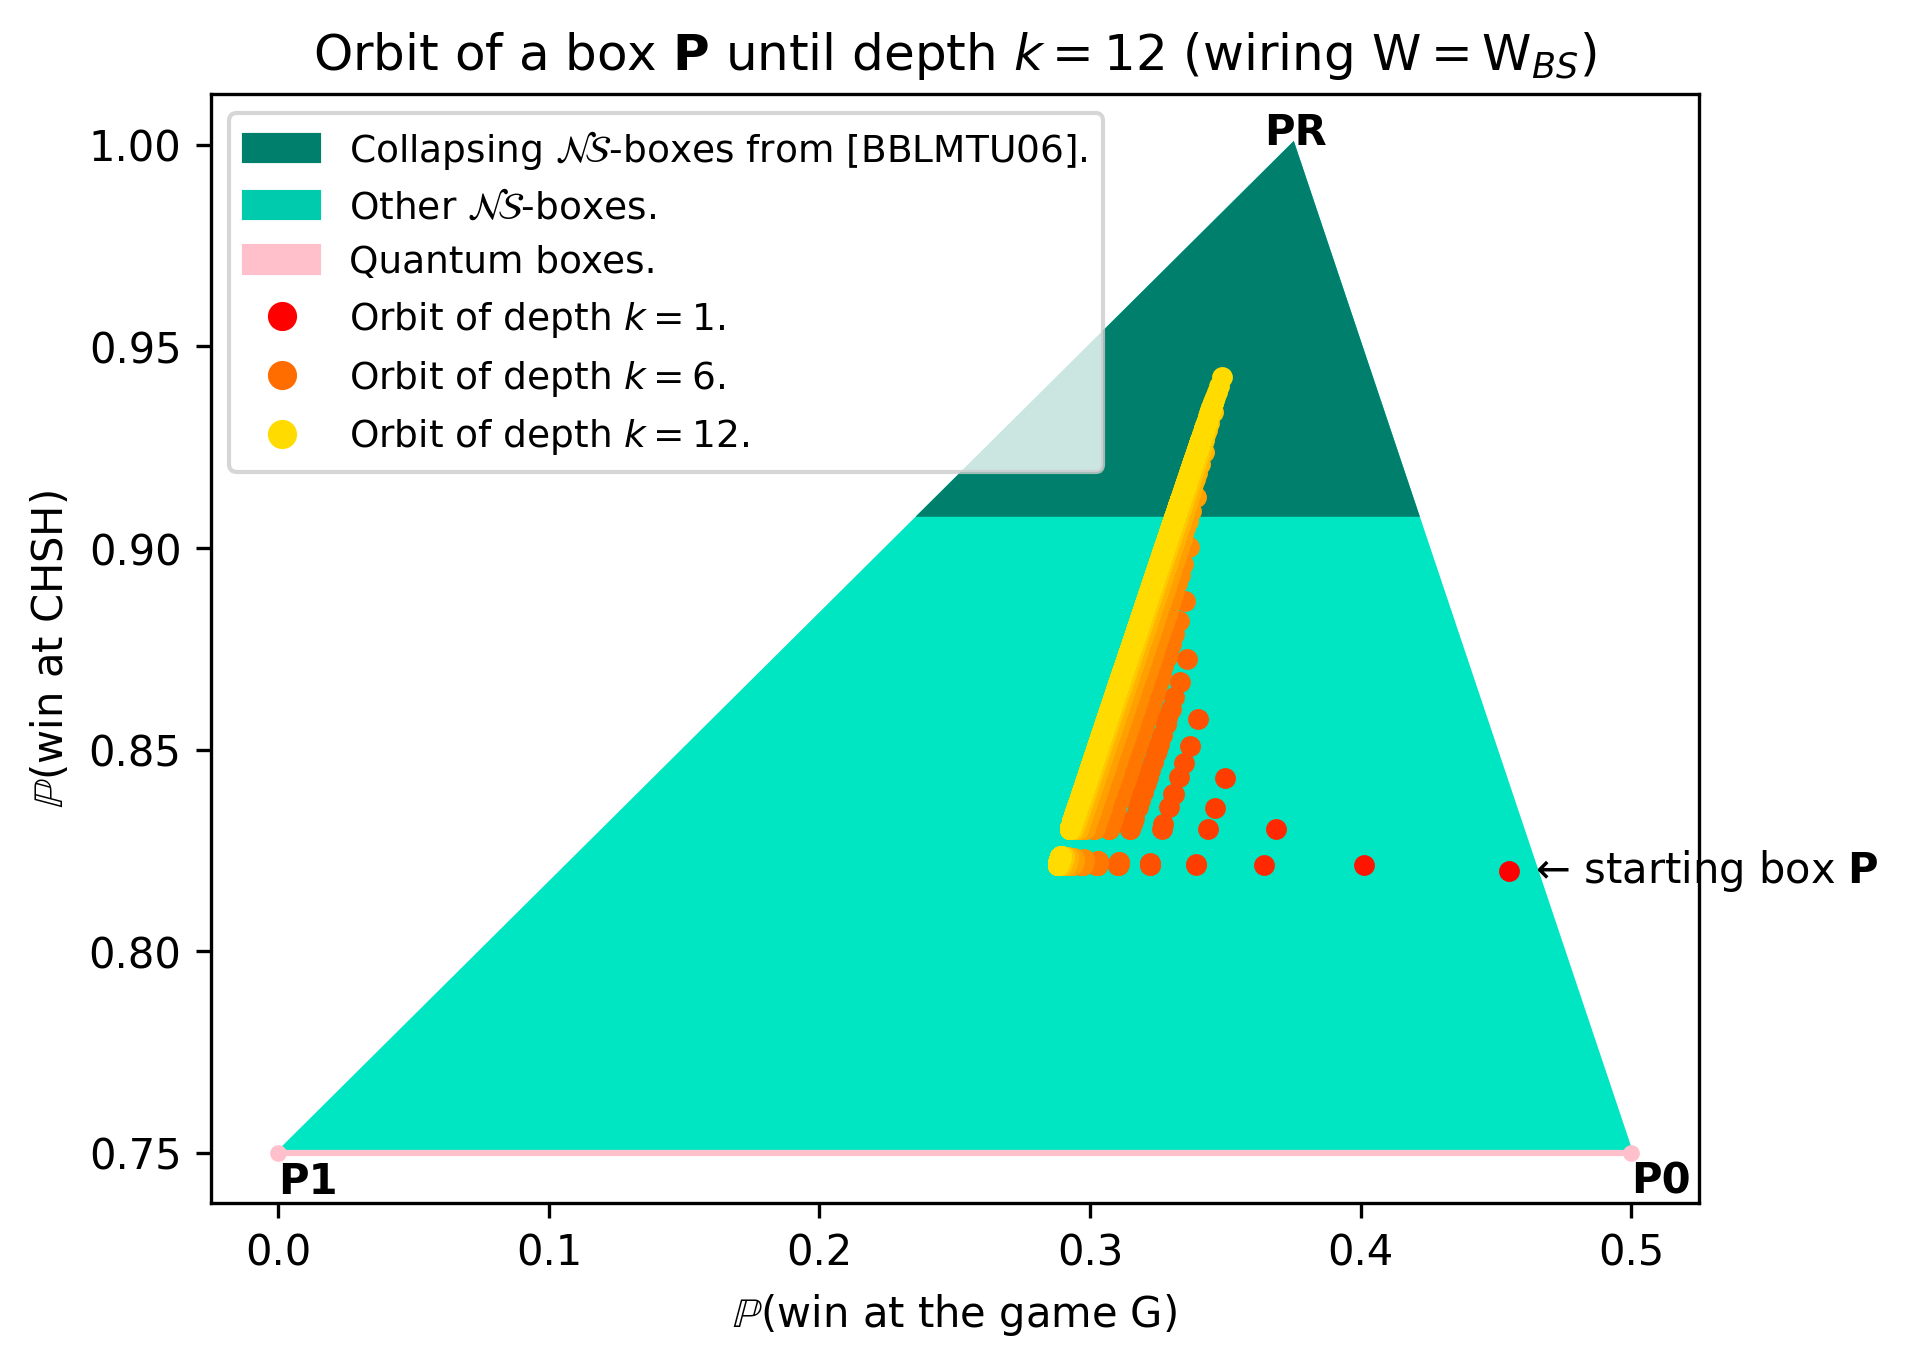

In [149]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.28, 0.7
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[0] )*1.
#W =  [0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,0.,1.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{BS}$",
    max_depth = 12,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x·a1
g_2(y,b1) = y·b1
f_3(x,a1,a2) = a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/1006821359.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


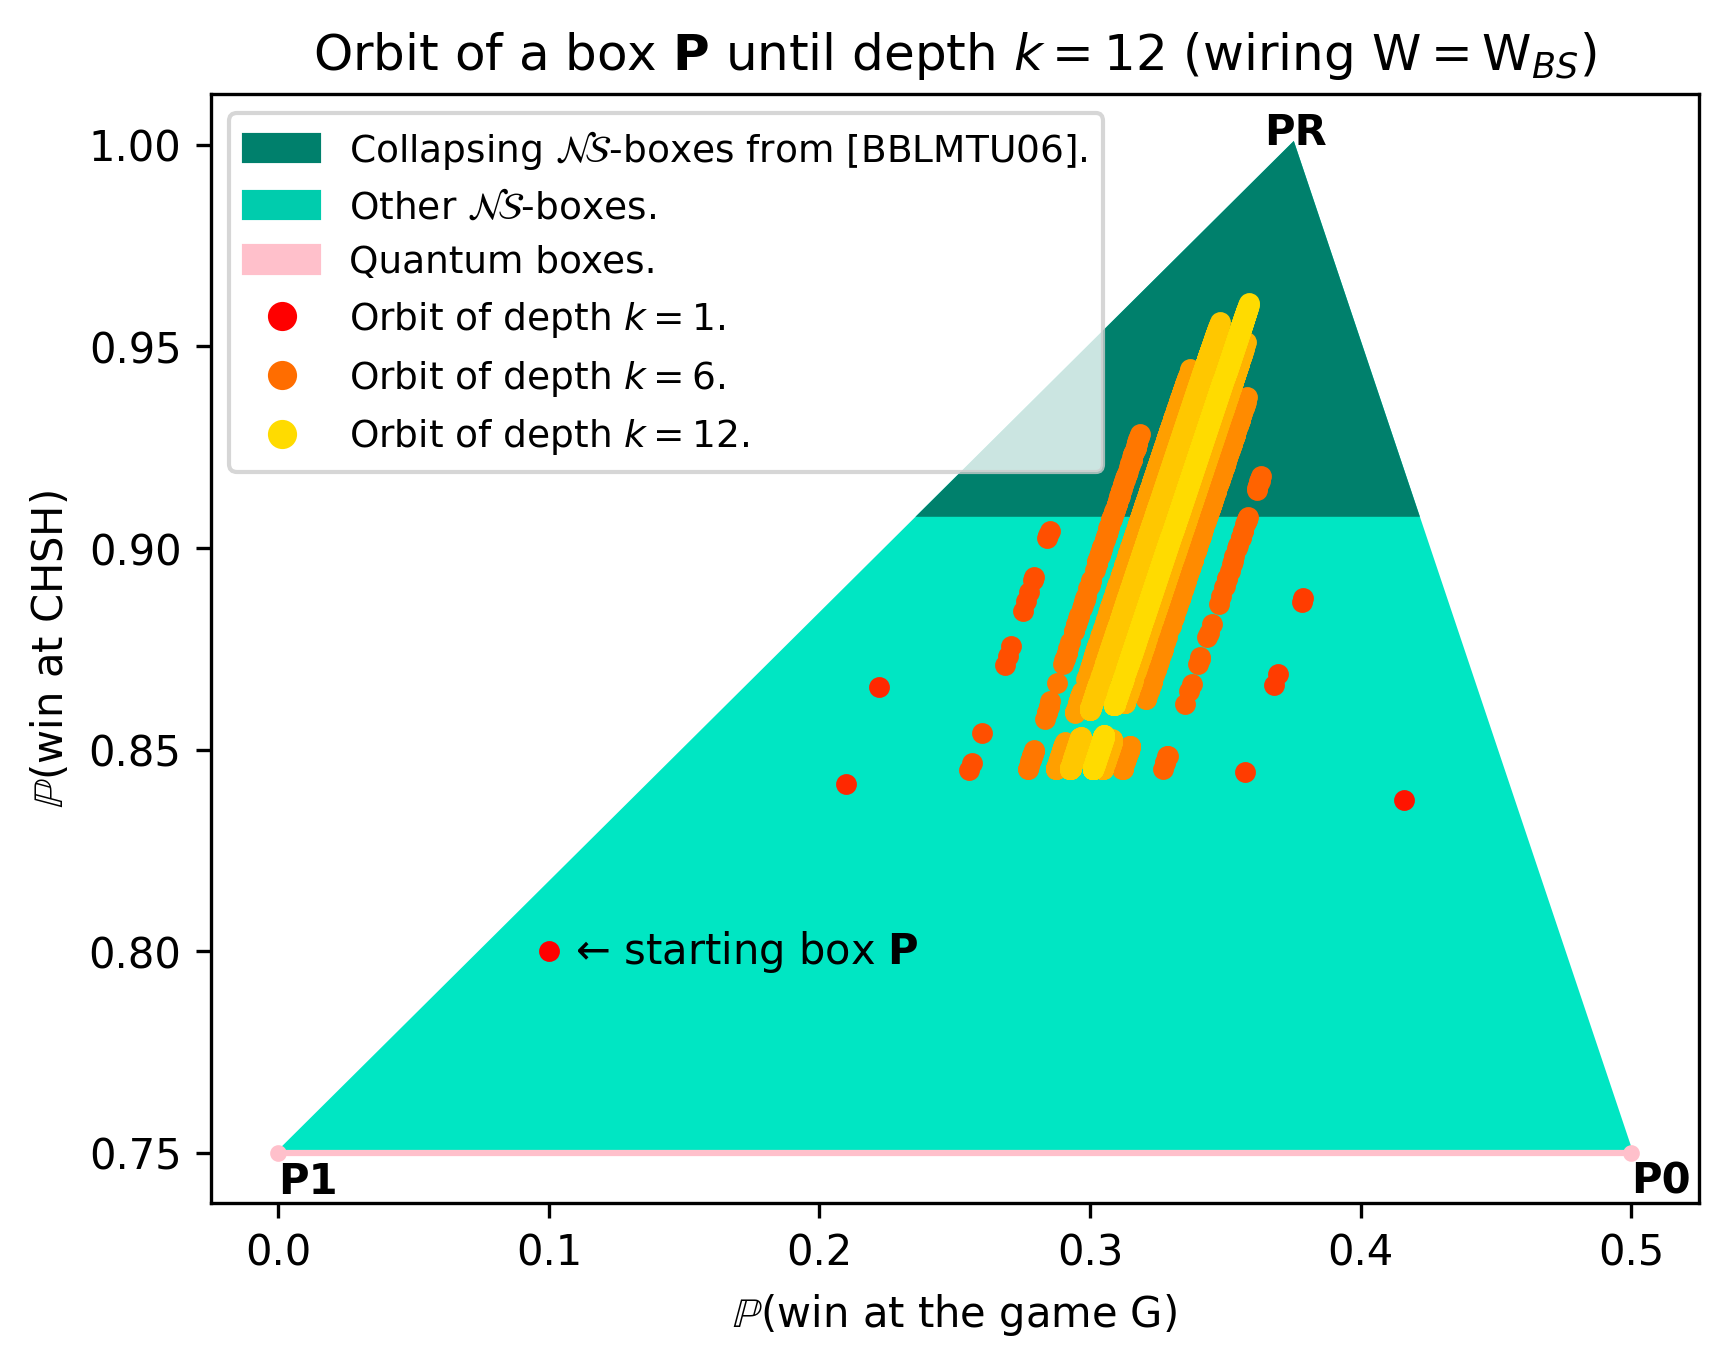

In [154]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.2, 0.05
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[0] )*1.
#W =  [0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,0.,1.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{BS}$",
    max_depth = 12,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x·a1
g_2(y,b1) = y·b1
f_3(x,a1,a2) = a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/559531600.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


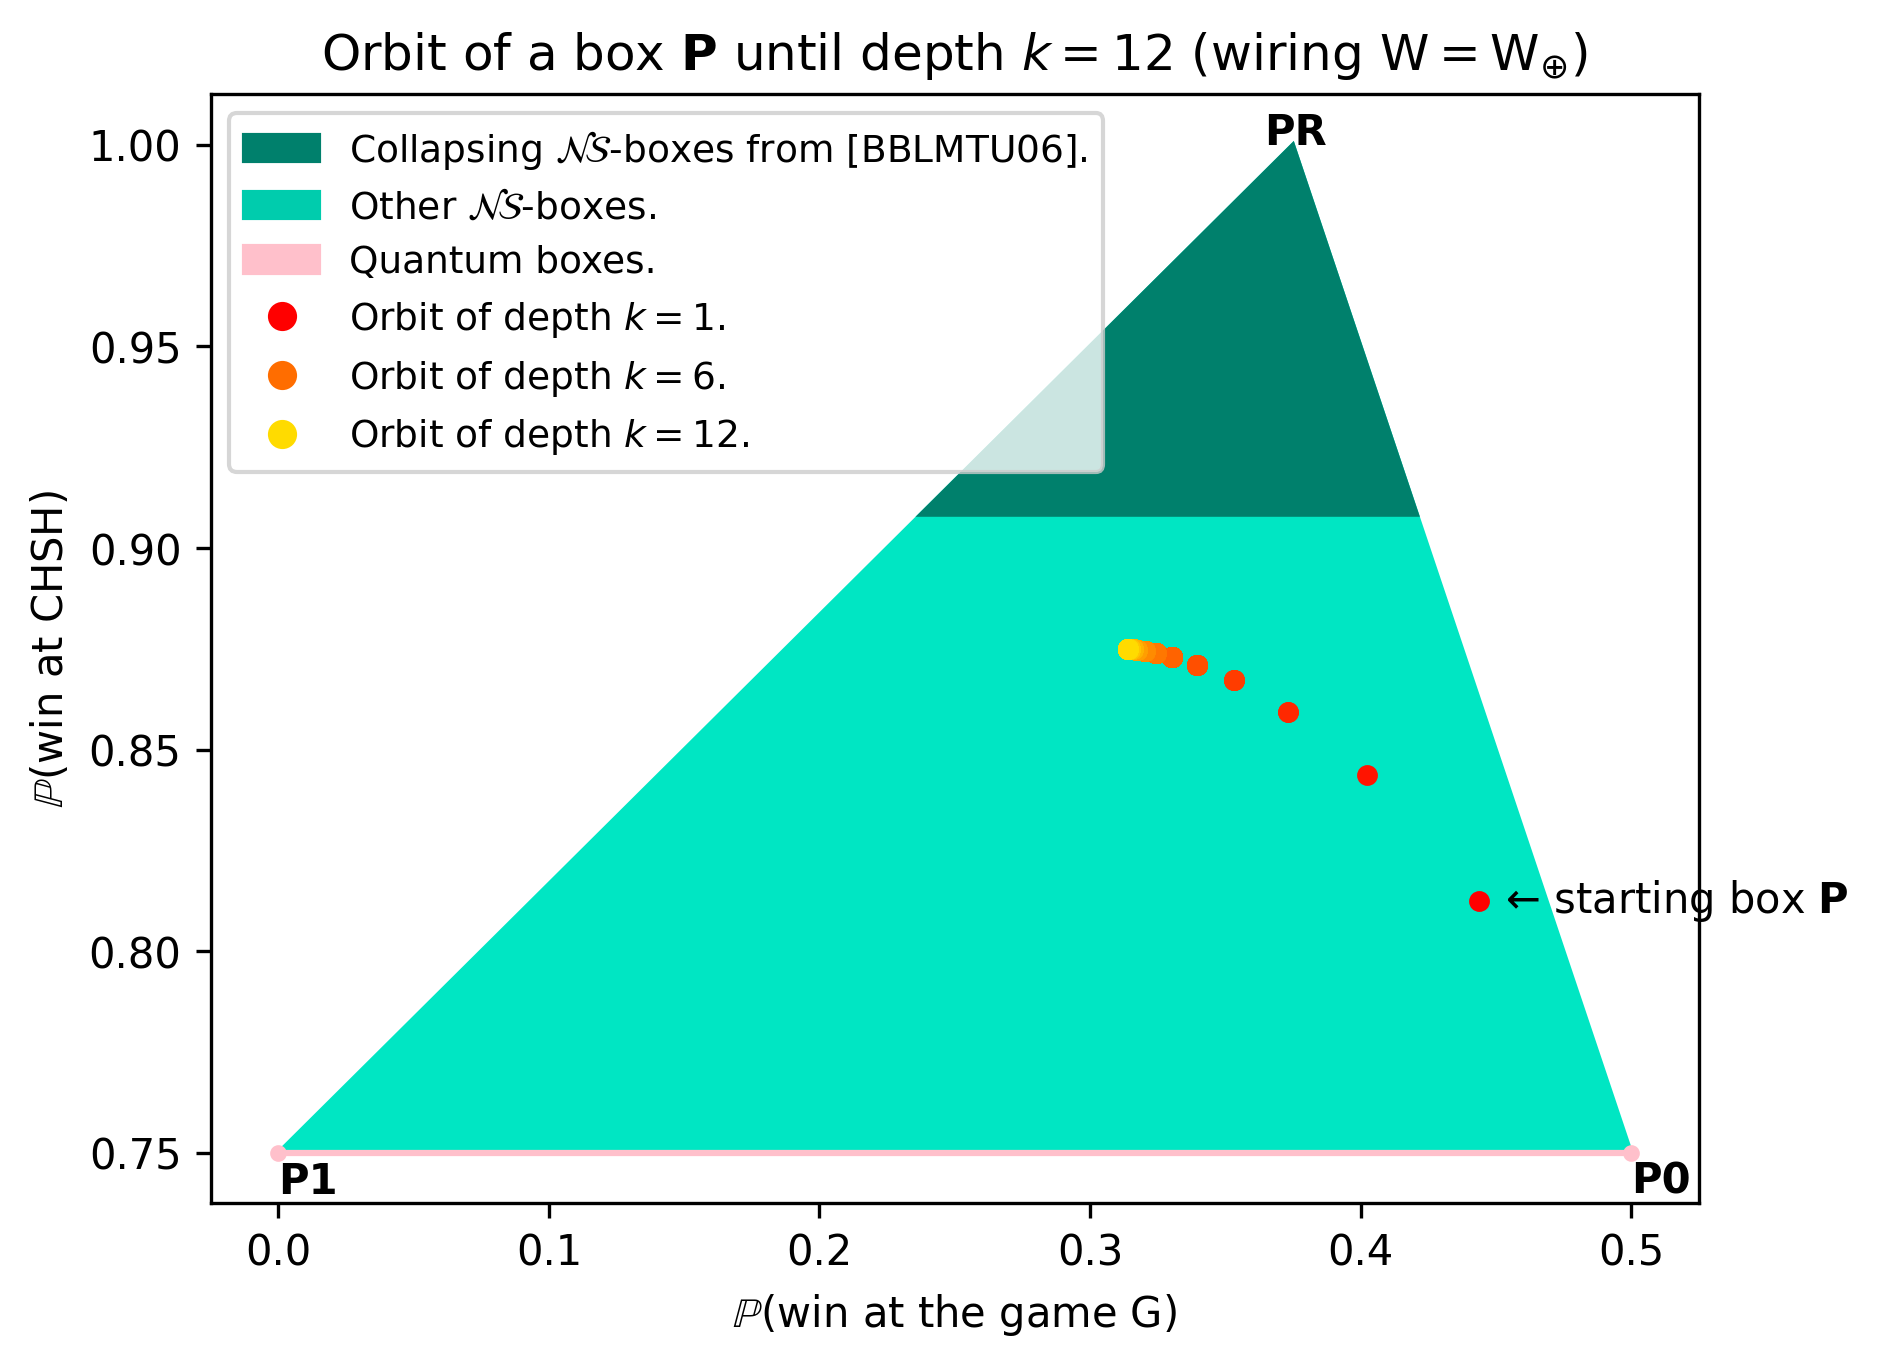

In [143]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.25, 0.7
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1

#W = torch.tensor(non_local_boxes.utils.known_collapsing_W[27] )*1.
#W =  [0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))
W=non_local_boxes.utils.W_FWW09(1)

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{\oplus}$",
    max_depth = 12,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x·a1
g_2(y,b1) = y·b1
f_3(x,a1,a2) = a1 ⊕ a2 ⊕ 1.0 
g_3(y,b1,b2) = b1 ⊕ b2 ⊕ 1.0 


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/1626940430.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


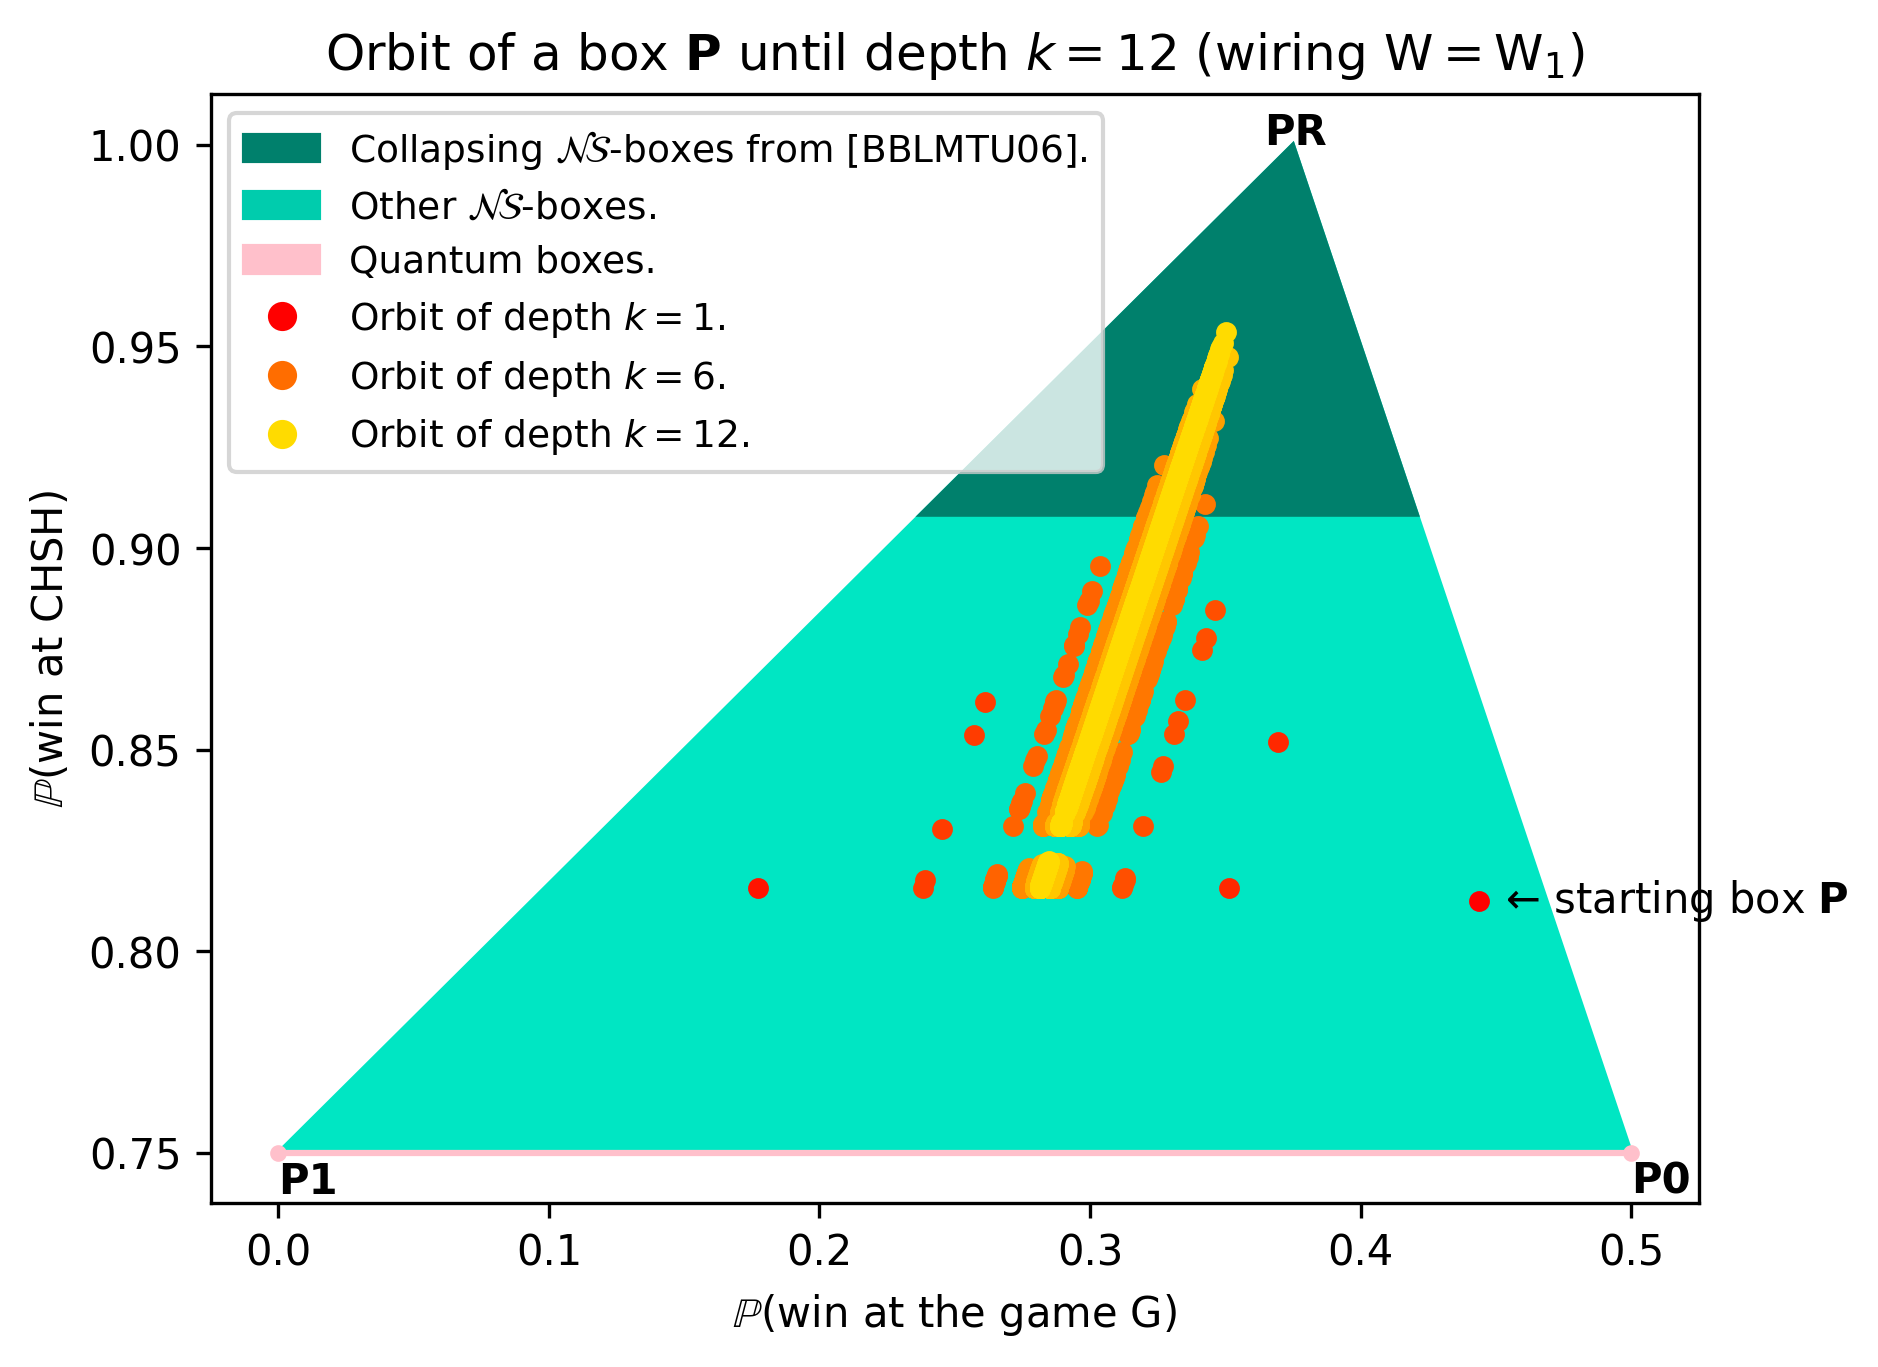

In [144]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.25, 0.7
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[27] )*1.
#W =  [0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{1}$",
    max_depth = 12,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x ⊕ x·a1
g_2(y,b1) = y ⊕ y·b1
f_3(x,a1,a2) = a1 ⊕ a2 ⊕ 1.0 
g_3(y,b1,b2) = b1 ⊕ b2 ⊕ 1.0 


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/112368139.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


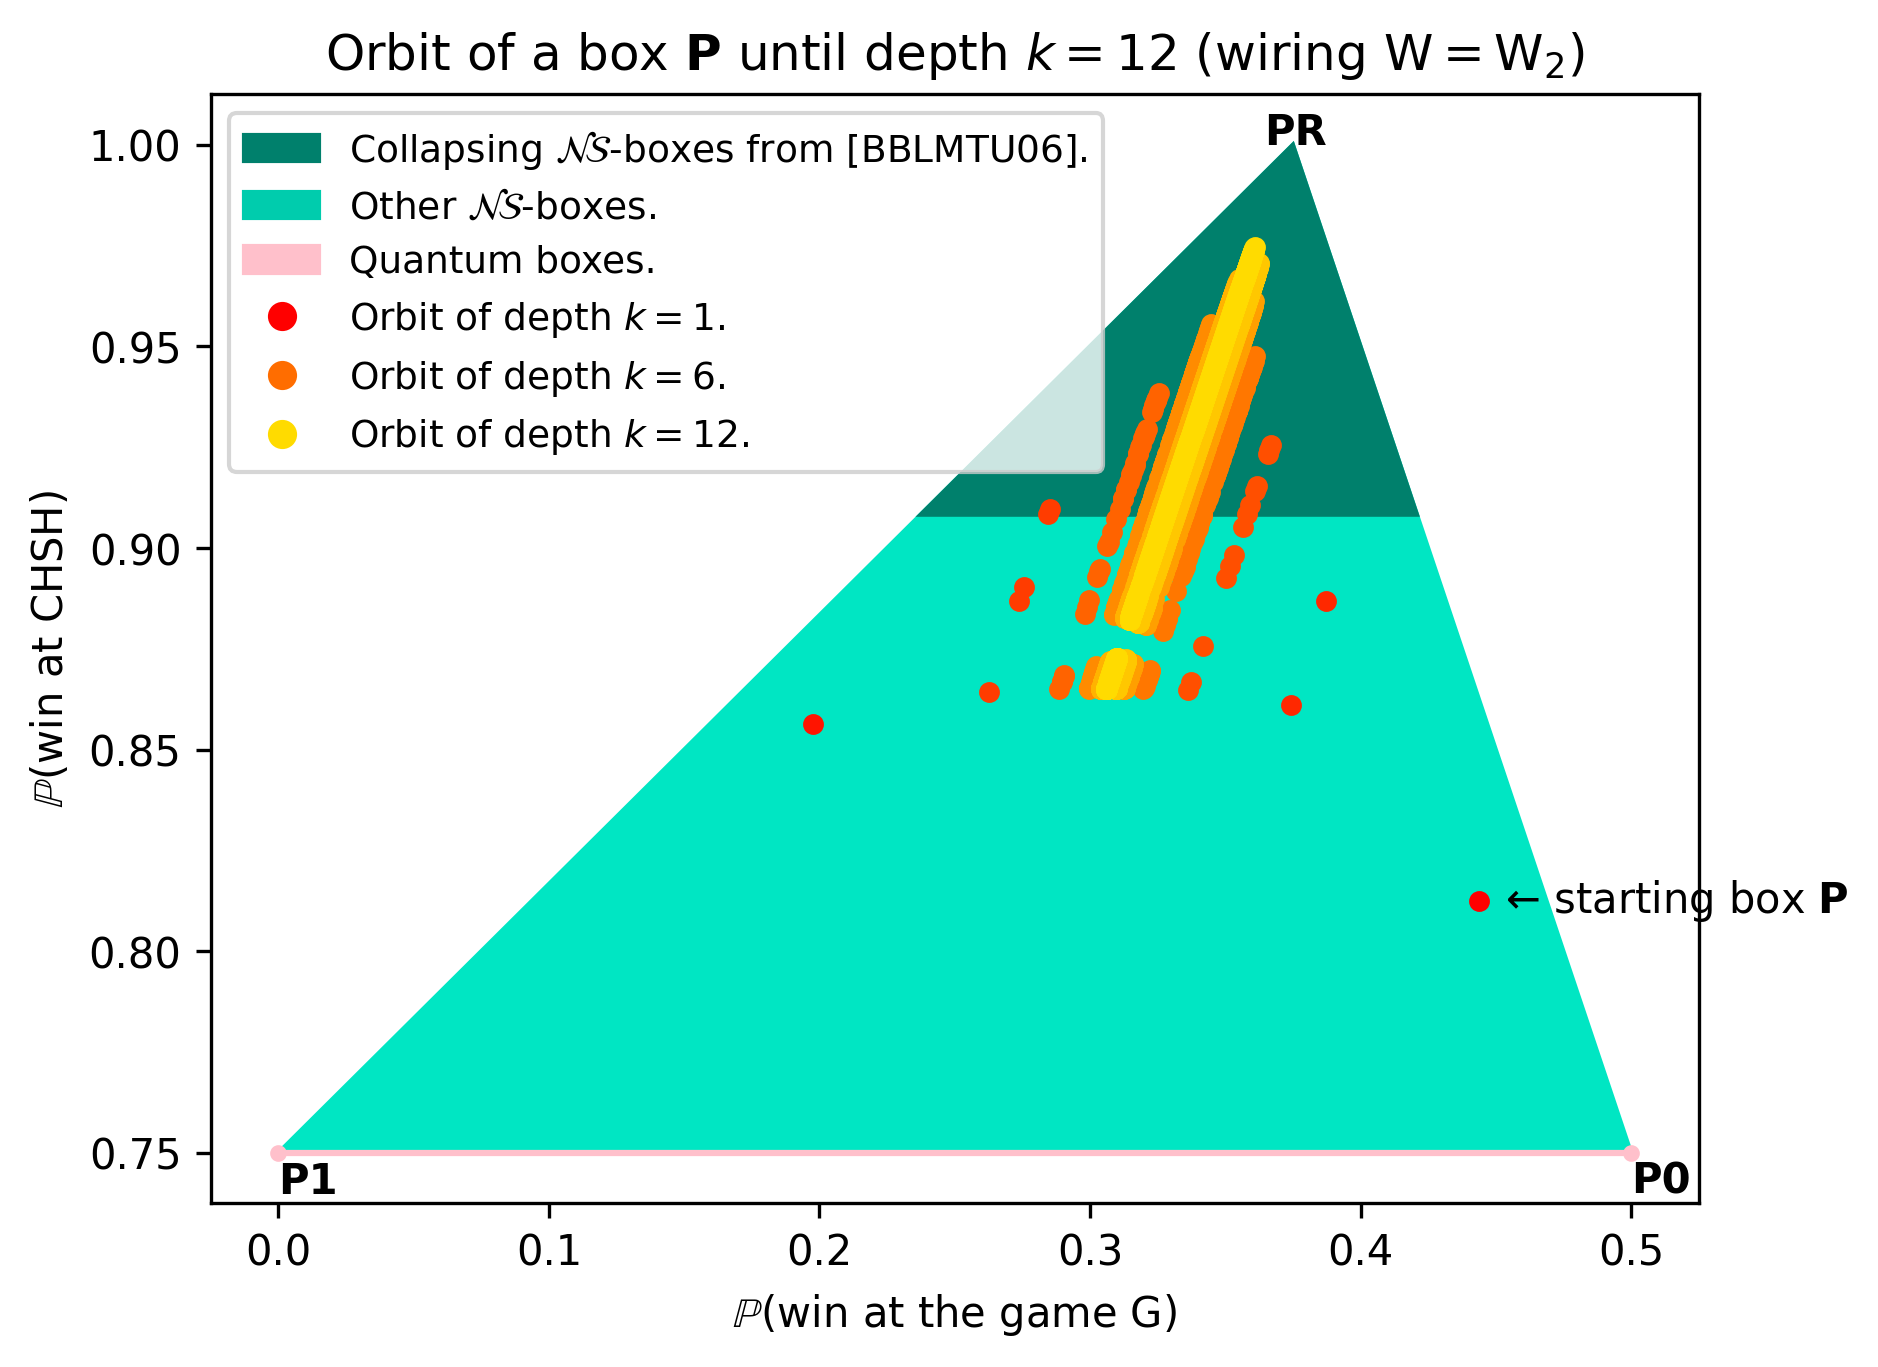

In [145]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.25, 0.7
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[21] )*1.
#W =  [0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,0.,1.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{2}$",
    max_depth = 12,
    precision_Q=0.0001
)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x ⊕ x·a1
g_2(y,b1) = y ⊕ y·b1
f_3(x,a1,a2) = a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_84359/2537601669.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


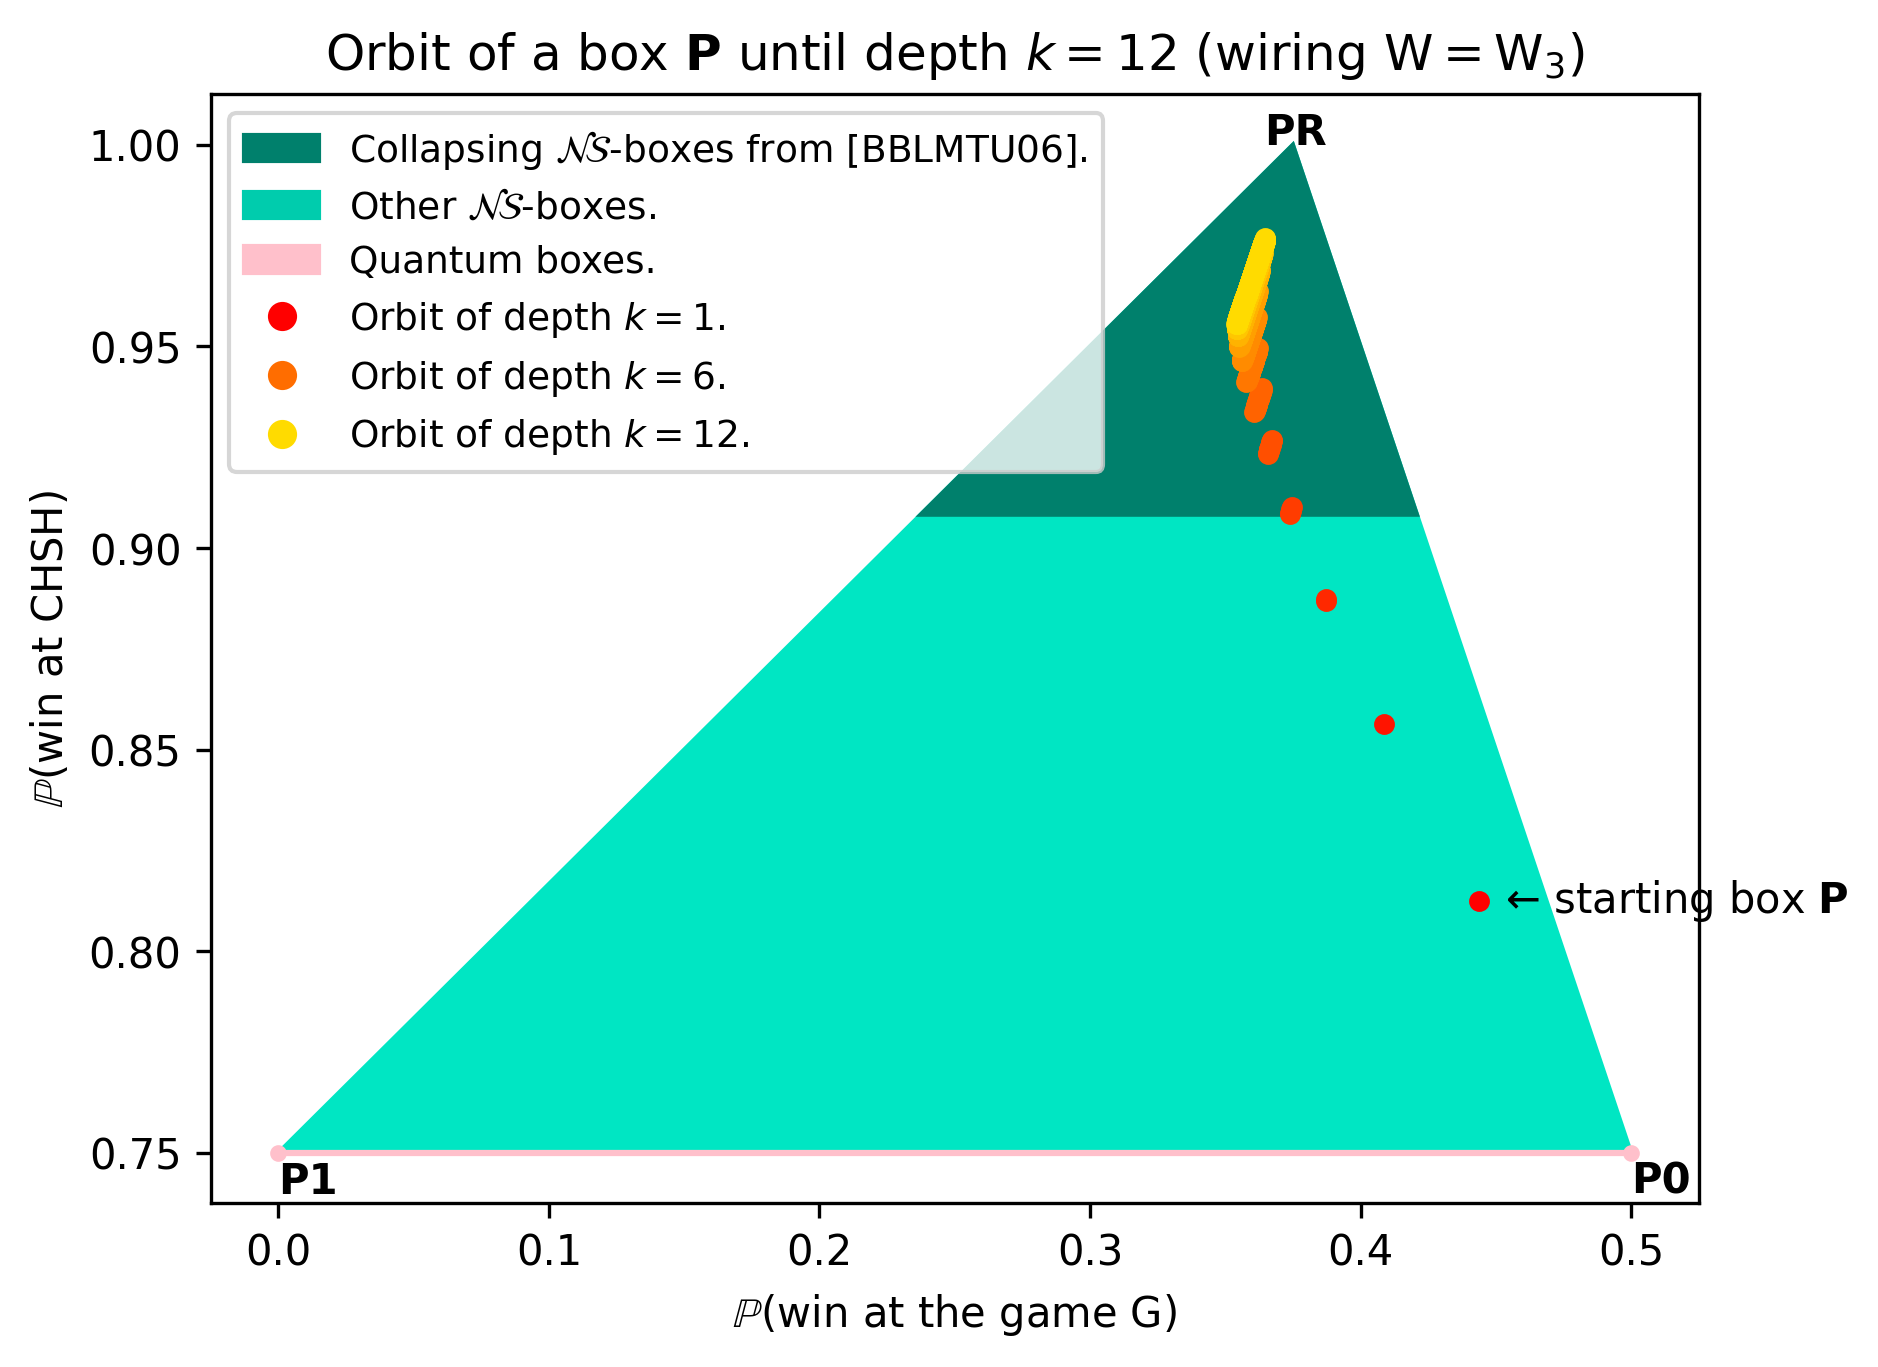

In [146]:
#alpha, beta, gamma = Compute_Coeff(PR, SR, I, CHSHprime_value=0.627, CHSH_value=0.862)
alpha, beta = 0.25, 0.7
P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
P1 = matrix_to_tensor(non_local_boxes.utils.P_1)
P = alpha*PR + beta*P0 + (1-alpha-beta)*P1

W = torch.tensor(non_local_boxes.utils.known_collapsing_W[16] )*1.
#W =  [0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)
W = torch.tensor(W)
W = torch.t(W.repeat(n, 1))

Draw_Orbit2(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = P0,
    P2name = "P0",
    P3 = P1,
    P3name = "P1",
    W = W,
    Wname = "$\mathsf{W}_{3}$",
    max_depth = 12,
    precision_Q=0.0001
)